### Imports

In [1]:
# general imports 
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
sns.set()

# model
from sklearn.neighbors import KNeighborsClassifier

# optuna
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING) 

# shap
import shap
shap.initjs()

# utils
from utils import *

In [2]:
df_train = pd.read_csv("train.csv")
df_valid = pd.read_csv("valid.csv")
df_test = pd.read_csv("test.csv")

X_train, y_train, X_valid, y_valid, X_test, y_test = with_resampling(df_train, df_valid, df_test)

### Optuna Hyperparameter Tuning

#### Finding hyperparameter with the best recall

In [3]:

def create_model(trial):
    leaf_size = trial.suggest_int("leaf_size", 1, 50)
    n_neighbors = trial.suggest_int("n_neighbors", 1, 30)
    p = trial.suggest_int("p",1,2)
    model = KNeighborsClassifier(leaf_size=leaf_size, n_neighbors=n_neighbors, p = p)
    return model

def model_performance(model, X = X_valid, y = y_valid):
    y_pred = model.predict(X)
    return recall_score(y, y_pred)

def objective(trial):
    model = create_model(trial)
    model.fit(X_train, y_train)
    return model_performance(model)

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100, timeout = 600)


In [4]:
trial_recall = study.best_trial
print(f"Trial of Choice: ")
print(f"\tnumber: {trial_recall.number}")
print(f"\tparams: {trial_recall.params}")
print(f"\tvalues: {trial_recall.values}")

Trial of Choice: 
	number: 21
	params: {'leaf_size': 22, 'n_neighbors': 29, 'p': 2}
	values: [0.8208955223880597]


In [5]:
knn = KNeighborsClassifier(**trial_recall.params)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_valid)
get_scores(y_valid, y_pred)


Precision: 0.071
Accuracy: 0.351
Recall: 0.821
F1: 0.130
Fbeta: 0.263
ROC AUC: 0.571
PR AUC: 0.069


<AxesSubplot: title={'center': 'Tuned for recall'}, xlabel='Predictions', ylabel='True Labels'>

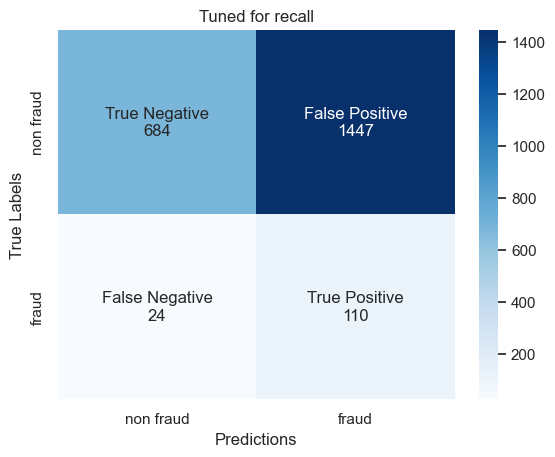

In [6]:

get_confusion_matrix(y_valid, y_pred,'Tuned for recall')

#### Finding hyperparameter with the best f2 score

In [7]:
def create_model(trial):
    leaf_size = trial.suggest_int("leaf_size", 1, 50)
    n_neighbors = trial.suggest_int("n_neighbors", 1, 30)
    p = trial.suggest_int("p",1,2)
    model = KNeighborsClassifier(leaf_size=leaf_size, n_neighbors=n_neighbors, p = p)
    return model

def model_performance(model, X = X_valid, y = y_valid):
    y_pred = model.predict(X)
    return fbeta_score(y, y_pred, beta = 2)

def objective(trial):
    model = create_model(trial)
    model.fit(X_train, y_train)
    return model_performance(model)

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100, timeout = 600)

In [8]:
trial_fbeta = study.best_trial

print(f"Trial of Choice: ")
print(f"\tnumber: {trial_fbeta.number}")
print(f"\tparams: {trial_fbeta.params}")
print(f"\tvalues: {trial_fbeta.values}")

Trial of Choice: 
	number: 98
	params: {'leaf_size': 34, 'n_neighbors': 16, 'p': 2}
	values: [0.2631578947368421]


In [9]:
knn = KNeighborsClassifier(**trial_fbeta.params)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_valid)
get_scores(y_valid, y_pred)

Precision: 0.073
Accuracy: 0.412
Recall: 0.761
F1: 0.133
Fbeta: 0.263
ROC AUC: 0.576
PR AUC: 0.070


<AxesSubplot: title={'center': 'Tuned for fbeta'}, xlabel='Predictions', ylabel='True Labels'>

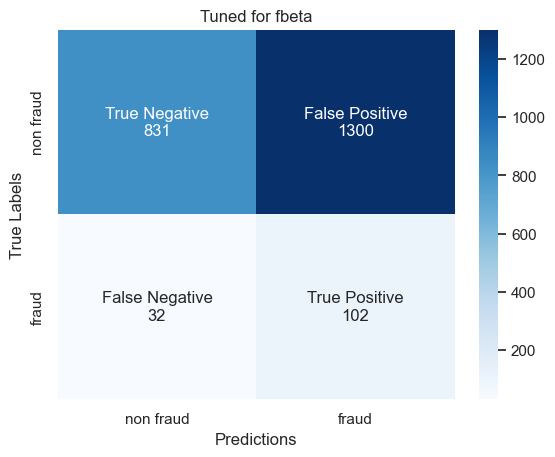

In [10]:

get_confusion_matrix(y_valid, y_pred,'Tuned for fbeta')

#### Making predictions on test set

In [15]:
knn = KNeighborsClassifier(**trial_fbeta.params)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
get_scores(y_test, y_pred)

Precision: 0.068
Accuracy: 0.432
Recall: 0.672
F1: 0.123
Fbeta: 0.241
ROC AUC: 0.544
PR AUC: 0.065


<AxesSubplot: title={'center': 'Test set results'}, xlabel='Predictions', ylabel='True Labels'>

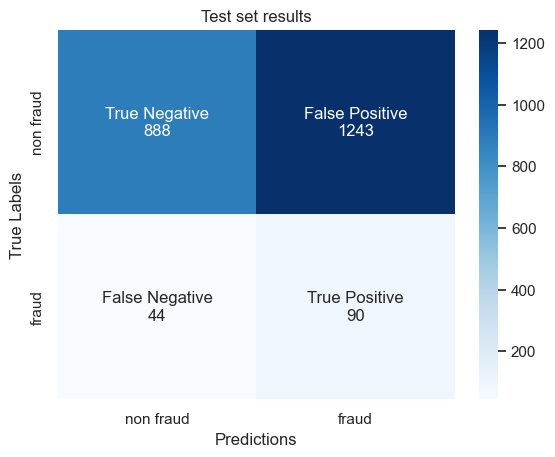

In [16]:
get_confusion_matrix(y_test, y_pred,'Test set results')

### SHAP

In [12]:
explainer = shap.Explainer(knn.predict, X_train, seed=0)
shap_values = explainer(X_train[1:100,:])

Permutation explainer: 100it [02:38,  1.68s/it]                       


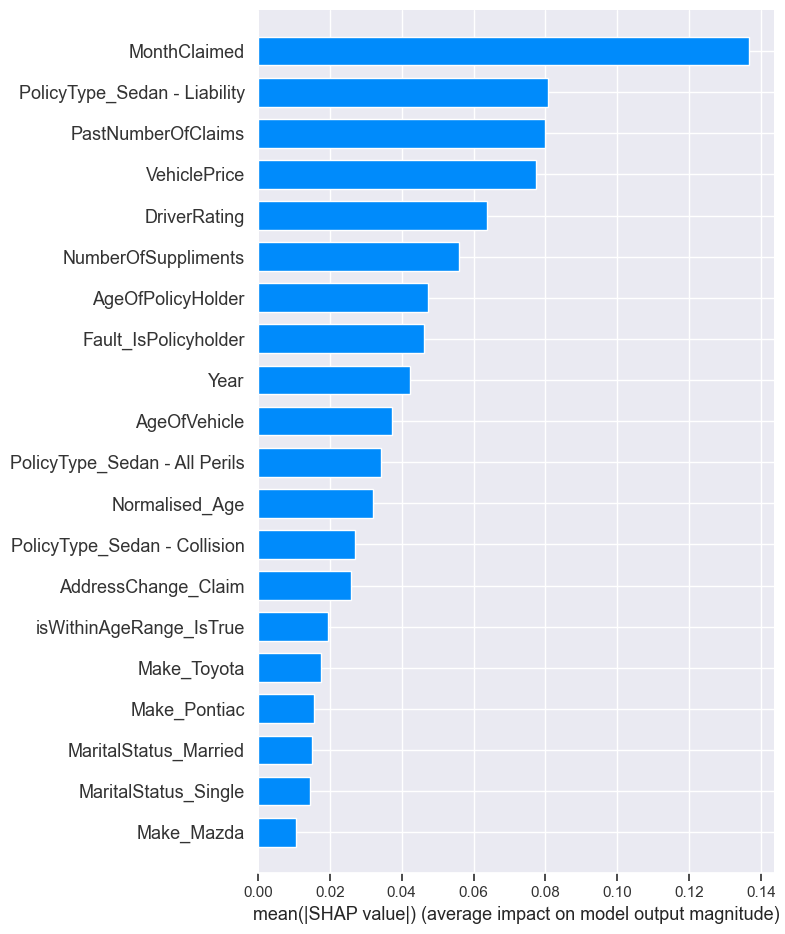

In [13]:
features = df_train.drop('FraudFound_P', axis=1).columns.tolist()
shap.summary_plot(shap_values, X_train, plot_type="bar", feature_names=features)

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

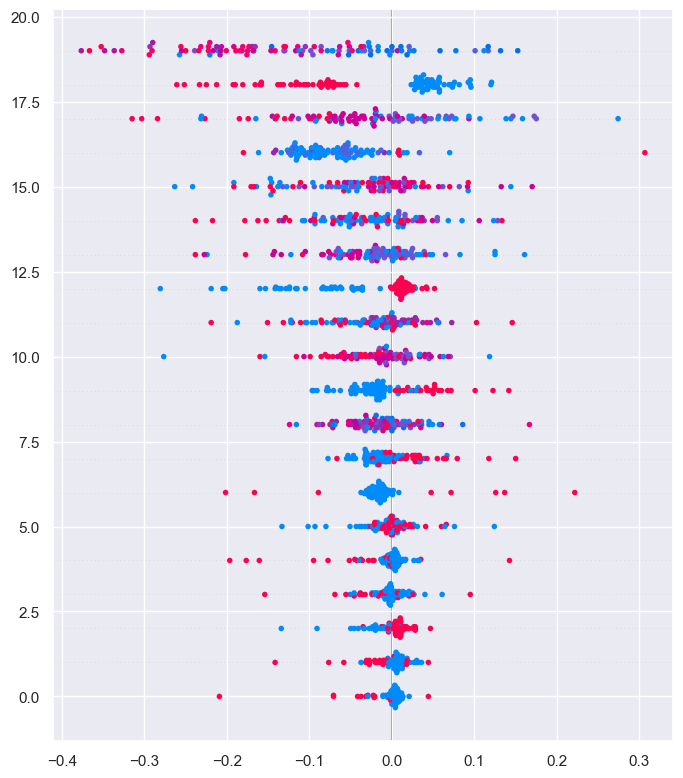

In [14]:

shap.summary_plot(shap_values, X_train[1:1000,:], feature_names=features)

In [ ]:
# f = lambda x: knn.predict_proba(x)[:,1]
# med = X_train.median().values.reshape((1,X_train.shape[1]))

# explainer = shap.Explainer(f, med)
# shap_values = explainer(X_test.iloc[0:1000,:])
